# **Import Libraries**

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import RocCurveDisplay
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib
from google.colab import files

# **Train Model**


> We used a separate dataset that had already been transformed to train the model.

## *Training the Model with XGBoost*

In [44]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier
import joblib

# Load data
df = pd.read_csv("Ultimate1_df.csv")

# Select relevant columns
features = ['SYSTEM_ID', 'PERCENTAGE_UNPAID_INVOICES', 'PERCENTAGE_LATE_INVOICES',
            'MID_YEAR_PCT', 'FINAL_YEAR_PCT', 'Attendance_Percentage']
target = 'CHURN'

# Keep only the relevant columns
df_model = df[features + [target]].copy()

# Handle missing values (fill with median for numeric columns)
for col in features:
    df_model[col] = df_model[col].fillna(df_model[col].median())

# Define X and y (keep as DataFrame/Series, not list of strings)
X = df_model[features]
y = df_model[target]

# Scale features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=features)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# Train XGBoost model
model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print results
print(report)
print("Accuracy:", accuracy)
print("ROC AUC:", roc_auc)
print("Confusion Matrix:\n", conf_matrix)

# Save model
joblib.dump(model, "churn_model.pkl")
print('Model saved to churn_model.pkl')


              precision    recall  f1-score   support

           0       0.98      0.97      0.97       267
           1       0.90      0.93      0.92        82

    accuracy                           0.96       349
   macro avg       0.94      0.95      0.94       349
weighted avg       0.96      0.96      0.96       349

Accuracy: 0.9598853868194842
ROC AUC: 0.9484333607381017
Confusion Matrix:
 [[259   8]
 [  6  76]]
Model saved to churn_model.pkl


In [45]:
print(accuracy, roc_auc)


0.9598853868194842 0.9484333607381017


## *Visualising the Model*

In [49]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Create a DMatrix for feature importance
tree_dump = model.get_booster().get_dump(dump_format='text')
print("Tree #0:")
print(tree_dump)


Tree #0:
['0:[PERCENTAGE_LATE_INVOICES<0.536547244] yes=1,no=2,missing=2\n\t1:[PERCENTAGE_LATE_INVOICES<-0.453200132] yes=3,no=4,missing=4\n\t\t3:[FINAL_YEAR_PCT<-2.01579332] yes=7,no=8,missing=8\n\t\t\t7:[Attendance_Percentage<-0.805410981] yes=13,no=14,missing=14\n\t\t\t\t13:leaf=0.0288192574\n\t\t\t\t14:leaf=-0.0805303156\n\t\t\t8:leaf=-0.1263033\n\t\t4:[PERCENTAGE_LATE_INVOICES<-0.183691442] yes=9,no=10,missing=10\n\t\t\t9:[Attendance_Percentage<0.0722221211] yes=15,no=16,missing=16\n\t\t\t\t15:leaf=0.30590114\n\t\t\t\t16:leaf=0.016159229\n\t\t\t10:[PERCENTAGE_LATE_INVOICES<-0.0994699746] yes=17,no=18,missing=18\n\t\t\t\t17:[MID_YEAR_PCT<-1.33782375] yes=23,no=24,missing=24\n\t\t\t\t\t23:leaf=-0.028215019\n\t\t\t\t\t24:leaf=-0.120327763\n\t\t\t\t18:[PERCENTAGE_LATE_INVOICES<0.153194413] yes=25,no=26,missing=26\n\t\t\t\t\t25:leaf=0.309393227\n\t\t\t\t\t26:leaf=-0.052374769\n\t2:[PERCENTAGE_LATE_INVOICES<1.21848214] yes=5,no=6,missing=6\n\t\t5:[PERCENTAGE_LATE_INVOICES<1.16385198] ye

/usr/local/lib/python3.11/dist-packages/xgboost/plotting.py:267: FutureWarning: The `num_trees` parameter is deprecated, use `tree_idx` insetad. 
  warnings.warn(


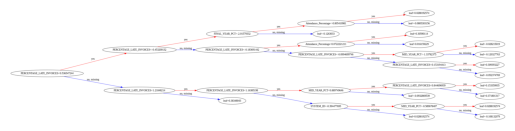

In [50]:
# Visualize the first tree
xgb.plot_tree(model, num_trees=0, rankdir='LR')  # Left-to-Right layout
plt.savefig("tree_visualization.png", dpi=300, bbox_inches='tight')


<Figure size 1000x1000 with 0 Axes>

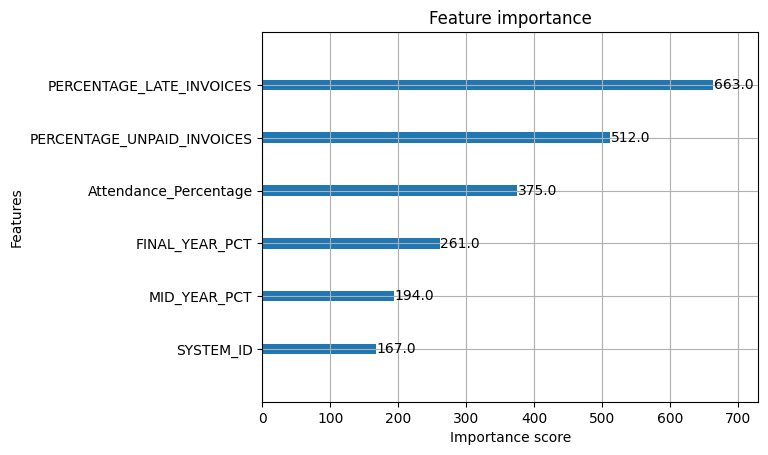

In [51]:
plt.figure(figsize=(10, 10))
xgb.plot_importance(model, max_num_features=10)
plt.savefig("feature_importance.png", dpi=300, bbox_inches='tight')

# **Data Transformation**

## Attendance Data

In [57]:
def transform_all_attendance_data(df1, df2, df3, df4):
  df_t=pd.concat([df1, df2, df3, df4].copy(), ignore_index=True)
  df_t['ATT_STATUS'] = df_t['ATT_STATUS'].replace({
      'O': 'P',  # Others => Present
  })
  # Step 1: Convert ATT_DATE to datetime (if not already done)
  df_t['ATT_DATE'] = pd.to_datetime(df_t['ATT_DATE'], format='%d-%b-%Y')

  # Step 2: Filter for academic year
  start_date = df_t['ATT_DATE'].min()
  end_date = df_t['ATT_DATE'].max()
  acad_year_df = df_t[(df_t['ATT_DATE'] >= start_date) & (df_t['ATT_DATE'] <= end_date)]

  # Step 3: Total attendance records per student
  total_attendance = acad_year_df.groupby('SYSTEM_ID').size().reset_index(name='Total_Days_Recorded')

  # Step 4: Filter only 'Present' days
  present_df = acad_year_df[acad_year_df['ATT_STATUS'] == 'P']
  present_days = present_df.groupby('SYSTEM_ID').size().reset_index(name='Present_Days')

  # Step 5: Merge both to calculate percentage
  full_att = pd.merge(total_attendance, present_days, on='SYSTEM_ID', how='left').copy()

  # Fill NaN in Present_Days with 0 (some students may have 0 presence)
  full_att['Present_Days'] = full_att['Present_Days'].fillna(0)

  # Step 6: Calculate Attendance Percentage with protection for zero total days
  full_att['Attendance_Percentage'] = full_att.apply(
      lambda row: (row['Present_Days'] / row['Total_Days_Recorded']) * 100 if row['Total_Days_Recorded'] > 0 else 0,
      axis=1
  )

  # Optional: Round to 2 decimal places
  full_att['Attendance_Percentage'] = full_att['Attendance_Percentage'].round(2)
  return full_att

## Invoice Data

In [58]:
def transform_invoice_data(df):
    """
    Transform raw invoice data into aggregated invoice metrics by SYSTEM_ID.

    Parameters:
        df (pd.DataFrame): Raw invoice DataFrame.

    Returns:
        pd.DataFrame: Aggregated DataFrame with invoice features.
    """

    # Ensure date columns are parsed
    date_cols = ["PAID_DATE", "DUE_DATE"]
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors="coerce")

    # Total invoices per SYSTEM_ID
    total_invoices = df.groupby("SYSTEM_ID").size().rename("TOTAL_INVOICES")

    # Unpaid invoices (no paid date)
    unpaid_invoices = df[df["PAID_DATE"].isna()].groupby("SYSTEM_ID").size().rename("UNPAID_INVOICES")

    # Late invoices (paid after due date)
    late_invoices = df[(df["PAID_DATE"].notna()) & (df["PAID_DATE"] > df["DUE_DATE"])].groupby("SYSTEM_ID").size().rename("LATE_INVOICES")

    # Merge into one DataFrame
    invoice_summary = pd.concat([total_invoices, unpaid_invoices, late_invoices], axis=1).fillna(0)

    # Percentages
    invoice_summary["PERCENTAGE_UNPAID_INVOICES"] = (invoice_summary["UNPAID_INVOICES"] / invoice_summary["TOTAL_INVOICES"]) * 100
    invoice_summary["PERCENTAGE_LATE_INVOICES"] = (invoice_summary["LATE_INVOICES"] / invoice_summary["TOTAL_INVOICES"]) * 100

    # Ensure integer counts
    invoice_summary[["TOTAL_INVOICES", "UNPAID_INVOICES", "LATE_INVOICES"]] = invoice_summary[["TOTAL_INVOICES", "UNPAID_INVOICES", "LATE_INVOICES"]].astype(int)

    invoice_summary.drop(columns=["TOTAL_INVOICES", "UNPAID_INVOICES", "LATE_INVOICES"], inplace=True)

    # Reset index
    return invoice_summary.reset_index()


## Grades Data

In [59]:
def transform_marks_data(marks_df):

    # Remove non-academic subjects
    non_academic_subjects = [
        "Visual Arts", "Music", "Physical Education", "Translation of the Holy Quran (Muslim Students Only)",
        "Computer Practical", "Library", "Drawing"
    ]
    marks_df = marks_df[~marks_df["SUBJECT_NAME"].isin(non_academic_subjects)]

    # Filter only Mid Year and End of Year
    filtered = marks_df[marks_df["TERM_NAME"].isin(["Mid Year", "End of Year"])]

    # Group by SYSTEM_ID and TERM_NAME, summing obtained and total marks
    grouped = filtered.groupby(["SYSTEM_ID", "TERM_NAME"])[["OBTAINED_MARKS", "TOTAL_MARKS"]].sum().reset_index()

    # Calculate percentage
    grouped["PERCENTAGE"] = (grouped["OBTAINED_MARKS"] / grouped["TOTAL_MARKS"]) * 100

    # Pivot to wide format
    pivot_df = grouped.pivot(index="SYSTEM_ID", columns="TERM_NAME", values="PERCENTAGE").reset_index()

    # Rename columns
    pivot_df.rename(columns={
        "Mid Year": "MID_YEAR_PCT",
        "End of Year": "FINAL_YEAR_PCT"
    }, inplace=True)

    return pivot_df



## Complete Transformation Function

In [60]:
def transform_all_data(inv_df, marks_df, df_a1, df_a2, df_a3, df_a4):
    # Clean SYSTEM_ID in marks and invoice data
    inv_df["SYSTEM_ID"] = pd.to_numeric(inv_df["SYSTEM_ID"].astype(str).str.replace(",", "", regex=False), errors="coerce").astype("Int64")
    marks_df["SYSTEM_ID"] = pd.to_numeric(marks_df["SYSTEM_ID"].astype(str).str.replace(",", "", regex=False), errors="coerce").astype("Int64")

    # Transform each dataset
    invoice_summary = transform_invoice_data(inv_df)
    marks_summary = transform_marks_data(marks_df)
    attendance_summary = transform_all_attendance_data(df_a1, df_a2, df_a3, df_a4)

    # Merge all three on SYSTEM_ID
    combined_df = pd.merge(invoice_summary, marks_summary, on="SYSTEM_ID", how="outer")
    combined_df = pd.merge(combined_df, attendance_summary, on="SYSTEM_ID", how="inner")

    # Fill NaN with 0 where numeric
    combined_df = combined_df.fillna(0)

    return combined_df


#**Providing Test Data**

In [61]:
df_a1 = pd.read_csv("att1.csv")
df_a2 = pd.read_csv("att2.csv")
df_a3 = pd.read_csv("att3.csv")
df_a4 = pd.read_csv("att4.csv")
invoices=pd.read_csv("invoices.csv")
marks=pd.read_csv("marks.csv")
df = transform_all_data(invoices, marks, df_a1, df_a2, df_a3, df_a4)
df

,SYSTEM_ID,PERCENTAGE_UNPAID_INVOICES,PERCENTAGE_LATE_INVOICES,FINAL_YEAR_PCT,MID_YEAR_PCT,Total_Days_Recorded,Present_Days,Attendance_Percentage
0,141541,0.0,0.000000,59.777778,70.666667,170,152.0,89.41
1,142849,0.0,27.272727,76.444444,76.333333,170,164.0,96.47
2,142913,0.0,0.000000,84.555556,85.666667,170,154.0,90.59
3,145572,0.0,0.000000,90.777778,92.333333,169,168.0,99.41
4,145887,0.0,8.333333,70.111111,77.000000,170,156.0,91.76
...,...,...,...,...,...,...,...,...
1272,345786,0.0,25.000000,41.528239,0.000000,32,27.0,84.38
1273,345815,0.0,25.000000,0.000000,0.000000,32,23.0,71.88
1274,346021,0.0,50.000000,0.000000,0.000000,32,26.0,81.25
1275,346073,75.0,0.000000,0.000000,0.000000,31,20.0,64.52


# **Running Model on Test Data**

## *Cleaning Test Data*

In [62]:
merged_df=df[['SYSTEM_ID', 'PERCENTAGE_UNPAID_INVOICES', 'PERCENTAGE_LATE_INVOICES',
                'MID_YEAR_PCT', 'FINAL_YEAR_PCT', 'Attendance_Percentage']]

# Check missing values
print("Any missing values?:", merged_df.isnull().values.any())
print("Rows with missing values:\n", merged_df[merged_df.isnull().any(axis=1)])
print("% missing values per column:\n", merged_df.isnull().mean() * 100)

# Fill missing values with median
for col in ['FINAL_YEAR_PCT', 'MID_YEAR_PCT']:
    merged_df[col] = merged_df[col].fillna(merged_df[col].median())

merged_df['FINAL_YEAR_PCT'] = merged_df['FINAL_YEAR_PCT'].fillna(merged_df['FINAL_YEAR_PCT'].median())
merged_df['MID_YEAR_PCT'] = merged_df['MID_YEAR_PCT'].fillna(merged_df['MID_YEAR_PCT'].median())


features = ['SYSTEM_ID', 'PERCENTAGE_UNPAID_INVOICES', 'PERCENTAGE_LATE_INVOICES',
            'MID_YEAR_PCT', 'FINAL_YEAR_PCT', 'Attendance_Percentage']

# ==== 3. Data cleaning (same as training) ====
# Keep only the relevant columns (if extra columns exist)
merged_df = merged_df[[col for col in features if col in merged_df.columns]]

# Fill missing numeric values with median from test data itself
for col in features:
    if col in merged_df.columns:
        merged_df[col] = merged_df[col].fillna(merged_df[col].median())

# ==== 4. Select cleaned feature matrix ====
X_new = merged_df[features]

scaler = StandardScaler()
X_new_scaled = scaler.fit_transform(X_new)

Any missing values?: False
Rows with missing values:
 Empty DataFrame
Columns: [SYSTEM_ID, PERCENTAGE_UNPAID_INVOICES, PERCENTAGE_LATE_INVOICES, MID_YEAR_PCT, FINAL_YEAR_PCT, Attendance_Percentage]
Index: []
% missing values per column:
 SYSTEM_ID                     0.0
PERCENTAGE_UNPAID_INVOICES    0.0
PERCENTAGE_LATE_INVOICES      0.0
MID_YEAR_PCT                  0.0
FINAL_YEAR_PCT                0.0
Attendance_Percentage         0.0
dtype: float64


/tmp/ipython-input-367989341.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col] = merged_df[col].fillna(merged_df[col].median())
/tmp/ipython-input-367989341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['FINAL_YEAR_PCT'] = merged_df['FINAL_YEAR_PCT'].fillna(merged_df['FINAL_YEAR_PCT'].median())
/tmp/ipython-input-367989341.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

## *Making Predictions*

In [63]:


# ==== 5. Make predictions ====
y_new_pred = model.predict(X_new_scaled)  # Predicted class (0 or 1)
y_new_proba = model.predict_proba(X_new_scaled)[:, 1]  # Probability of churn

# ==== 6. Add results to DataFrame ====
merged_df['Predicted_CHURN'] = y_new_pred
merged_df['Churn_Probability'] = y_new_proba


# Save results to Excel
merged_df.to_excel("predictions.xlsx", index=False)
print("Predictions saved to predictions.xlsx")
from google.colab import files
files.download("predictions.xlsx")


Predictions saved to predictions.xlsx


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>